### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that are not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [62]:
# Input
# from db import PythonProblems
# import io

# Helpers
import numpy as np

# Preprocessing
# import tokenize
# from sklearn.feature_extraction.text import CountVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel

# Learning
from sampling import get_next_sample

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport

%matplotlib inline

### Generate synthetic data

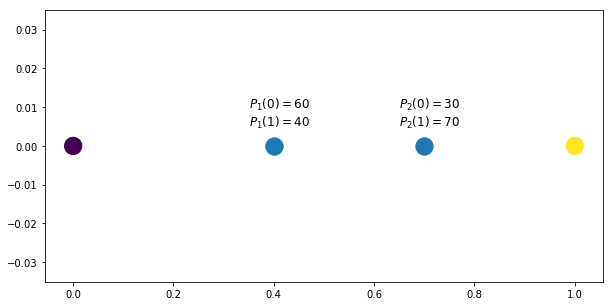

In [63]:
# Generate data
sample = np.zeros((4,2))
sample[0] = [0,0]
sample[1] = [0.4,0]
# sample[2] = [0,0]
sample[2] = [0.7,0]
sample[3] = [1,0]

fig = plt.figure(figsize=(10,5))
# plt.scatter(x=sample[:,0], y=sample[:,1])
ax = fig.add_subplot(111)

ax.text(0.35, 0.005, r'$P_1(0) = 60%%$' + '\n' + r'$P_1(1) = 40%%$', fontsize=12)
ax.text(0.65, 0.005, r'$P_2(0) = 30%%$' + '\n' + r'$P_2(1) = 70%%$', fontsize=12)

Y = np.zeros((4,2))
Y[0] = [0,1]
Y[1] = [0,1]
Y[2] = [1,0]
Y[3] = [1,0]

# Set L as a labelled set
L = [0, 3]

# Create the set of unlabelled samples (U)
U = np.setdiff1d(np.arange(nS), L)
# Plot unlabeled samples
plt.scatter(x=sample[U,0], y=sample[U,1], s=300)

# Color by class the ones already labeled
plt.scatter(x=sample[L,0], y=sample[L,1], c=Y[L,0], s=300)

In [84]:
X = np.zeros((4,2))
X[0] = [0,1]
X[3] = [1,0]
print(X.shape)

Y = np.zeros((4,2))
Y[0] = [0,1]
Y[1] = [0,1]
Y[2] = [1,0]
Y[3] = [1,0]

# Create W as a similarity matrix
# W = cosine_similarity(clustering.X) # nS x nS
W = rbf_kernel(sample, gamma=1) # nS x nS
print(W.shape)

# Set L as a labelled set
L = [0, 3]

(4, 2)
(4, 4)


$d_i = \sum_j w_{ij}$

$D = diag(d_i)$

The *combinatorial Laplacian* is the $n x n$ matrix:

$\Delta = D - W$

We partition the Laplacian matrix $\Delta$ into blocks for labeled and unlabeled nodes:

$\Delta = \begin{bmatrix}
\Delta_{ll} & \Delta_{lu} \\ 
\Delta_{ul} & \Delta_{uu} \\
\end{bmatrix}$

The harmonic minimizing function $f$ is defined as:

$f = \begin{bmatrix}
f_l \\
f_u
\end{bmatrix}$ where $fl = y_L$ and **$f_u$ denotes the mean values on the unlabeled data points**. The solution is given by:

$f_u = -\Delta_{uu}^{-1}\Delta_{ul}f_l$

The *true* risk $R(f)$ of the Bayes classifier based on the harmonic function $f$ is

$$R(f) = \sum_{i=1}^{n} \sum_{y_i=C_j}^{C_m} \left [ y_i \neq C_j \right ] p^\ast(y_i|L)$$

**This is the probability (weighted sum) that the class DOES NOT belong to the ground truth.**

Here, $p^\ast(y_i|L)$ is the unknown true label distribution at node $i$ given the labeled data. In order to proceed, we estimate this unknown distribution with the mean of the Gaussian field model:

$p^\ast(y_i=C|L)\approx f_{iC}$

The risk can then be written as:

$\hat{R}(f) = \sum_{i=1}^{n} 1 - \left[ y_i = C\right] p^{\ast}(yi=C|L)$

Performing active learning and querying an unlabeled node $k$, we will receive an answer $y_k$. Adding this point to the training set and retraining, the Gaussian field and its mean function will change. The new harmonic function is denoted by $f^{+(x_k,y_k)}$

The active learning criterion here is the greedy procedure of choosing the next query $k$ that minimizes the expected estimated risk:

$k = argmin_{k'}\hat{R}(f^{+x_{k'}})$

And  $f^{+(x_k,y_k)}$ can be calculated as:

$f_{u}^{+(x_k,y_k)} = f_u + (y_k - f_k) \frac{(\Delta_{uu}^{-1})_k}{(\Delta_{uu}^{-1})_{kk}}$

where $(\Delta_{uu}^{-1})_{k}$ of the $k$-th column of the inverse Laplacian on the unlabeled data, and $(\Delta_{uu}^{-1})_{kk}$ is the $k$-th diagonal element of the same matrix.

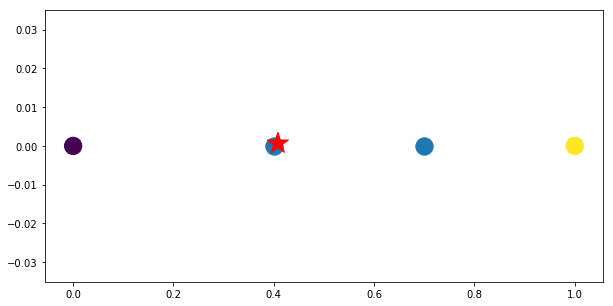

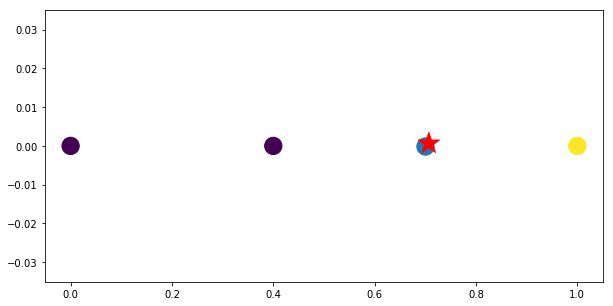

In [85]:
doc = PDFReport()
for i in range(2):
    # Get next sample
    sample_id = get_next_sample(X, Y, W, L)
    
    # Plot sample
    fig = plt.figure(figsize=(10,5))
    
    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape
    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)
    # Plot unlabeled samples
    plt.scatter(x=sample[U,0], y=sample[U,1], s=300)
    
    # Color by class the ones already labeled
    plt.scatter(x=sample[L,0], y=sample[L,1], c=Y[L,0], s=300)
    
    # Star the queried sample
    plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=800)
    
    # Save figure
    plt.savefig("images/solution_%d.png" % sample_id)
#     print("Question %d" % sample_id)
    
    # Print question
#     problem = questions[sample_id]
#     solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
    doc.append_solution(sample_id, '', '')

doc.generate_pdf("basic_example")

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).